
#<font size = 10> <b> Problem Set 4 </b><br><font size = 5>
<center><b> Dynamical System and Sequential Sampling Modeling </b><div class="row">            <img src="https://github.com/snamazova/task_switch/blob/e7588298264e89f120e693db5764d3386c6616c1/ezgif.com-video-to-gif-converter%20(1).gif?raw=true"            width=500 height=500> </img>             </div></center>

# Overview

This problem set covers:

- **Dynamical Systems Modeling**
- **Sequential Sampling Modeling**

In this problem set, you will:

- Explore a **task-switching experiment** to understand its dynamics.
- Work with **provided experimental data** to fit models.
- Implement and analyze two models:
  - **Model 1: Dynamical System**
    - Introduction
    - Implementation
    - Parameter recovery
  - **Model 2: Drift Diffusion Model (DDM)**
    - Introduction
    - Implementation
    - Parameter recovery

- **Bonus:** Perform model comparison for the Drift Diffusion Model to evaluate its performance under different parameter assumptions.

**Last date of submission: 11.02.2025**


## Package Download

In [3]:
# Run this cell to load the following libraries
!pip install cm-course-uos --upgrade
!pip install git+https://github.com/lnccbrown/HSSM.git
!pip install ipywidgets
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns
import hssm
import hssm.plotting
import arviz as az
import scipy
import warnings
from google.colab import files
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from IPython.display import clear_output
from ipywidgets import interact,fixed, widgets,FloatSlider
from cm_course_uos import problemset4

# Ensure consistency and avoid warnings
hssm.set_floatX("float32")
clear_output()
warnings.simplefilter(action='ignore', category=FutureWarning)

# Check scipy version
scipy.__version__ == "1.11.4"

False

#Part I: Task-Switching Experiment
In real-world data analysis, you often start with raw data and no predefined approach. So in this section, we’ll start to examine the task-switching experiment and explore its data to determine the best modeling strategy.

This notebook focuses on modeling data from a task-switching experiment—a classic paradigm for studying cognitive flexibility. For a detailed description of the original task-switching experiment, refer to the [PsyToolkit library](https://https://www.psytoolkit.org/experiment-library/taskswitching.html).

Let’s dive in!

## Task Setup and Data Preparation
Let's begin by understanding the setup of this task, which closely resembles *Roger and Monsell’s paradigm(1995)*. This paradigm is a classic cognitive psychology framework used to study task switching, a key aspect of cognitive control. It examines how individuals manage switching between different tasks, often requiring them to shift attention and update their mental focus. By analyzing response times and accuracy in different conditions, this paradigm helps us understand the cognitive costs of task switching.

In our task, we explore a similar concept by having participants respond to combinations of numbers and letters, each requiring specific responses based on predetermined rules.

Participants are presented with two task types, each involving a stimulus pair *(a letter and a number)* displayed in specific positions on a grid:  

### **1. Letter Task**
- **Stimuli Location**: Appears in the **top row** of the grid.  
- **Response Rules**:  
  - Respond to **consonants** (G, K, M, R) with the key **B**.  
  - Respond to **vowels** (A, E, I, U) with the key **N**.  

### **2. Number Task**
- **Stimuli Location**: Appears in the **bottom row** of the grid.  
- **Response Rules**:  
  - Respond to **odd numbers** (3, 5, 7, 9) with the key **N**.  
  - Respond to **even numbers** (2, 4, 6, 8) with the key **B**.  

### Example
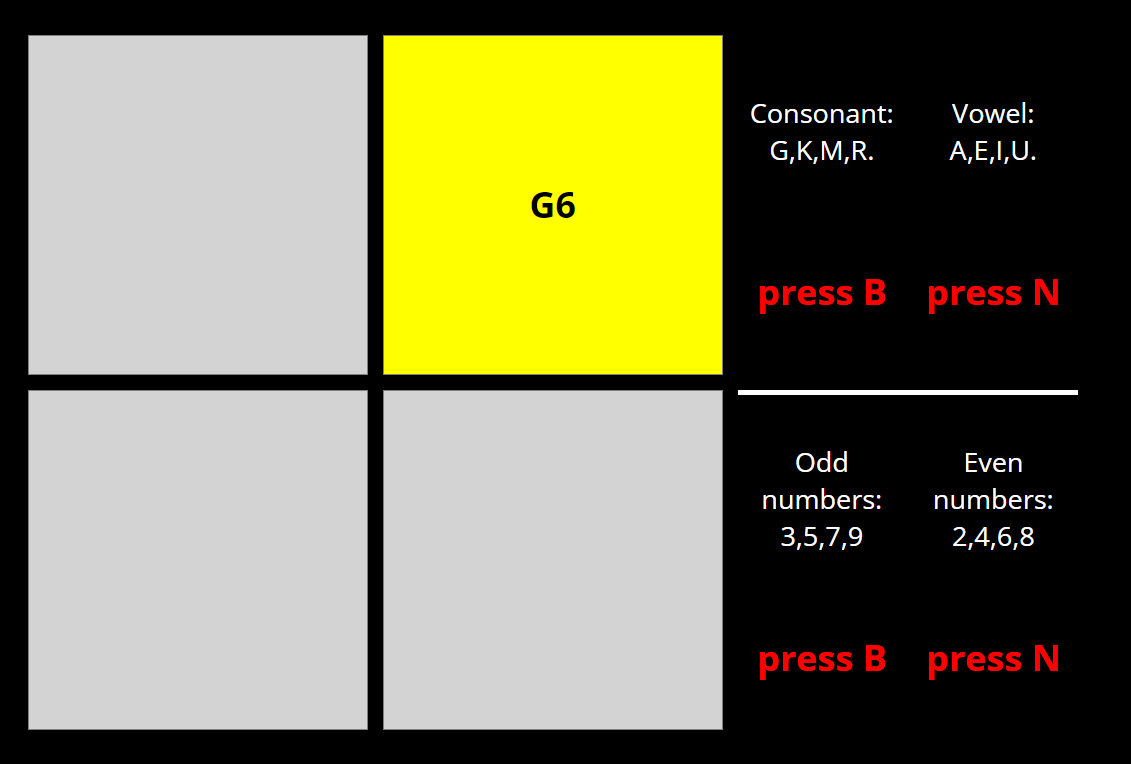
In this case, the participant needs to respond to <span style="color:yellow">G</span> and ignore *6*. Since <span style="color:yellow">G</span> is a consonant, the correct response would be **pressing the key B**.  

## Data Analysis and Visualization

Having covered the task setup and rules, we now shift our focus to analyzing the data. Through visualization, we aim to uncover the patterns and trends in participants' responses, helping us to better understand the results of the experiment.

### **Data Description (Exploratory Data Analysis)**

The first step in working with any dataset is to understand its structure and content. **Data description** involves an initial examination of the dataset to get a sense of what is available, what types of variables exist, and what the overall distribution looks like. This typically includes using methods like `.info()` and `.describe()` to get an overview of the number of records, missing values, data types, and basic statistics such as mean, standard deviation, minimum, and maximum values. In addition, inspecting the first few rows of the dataset with `.head()` gives a quick sense of how the data is organized.

In [4]:
url='https://github.com/snamazova/task_switch/blob/5e291169e5cbf26dac87bcf73d46e5cd10a68b34/cleaned_data.csv?raw=true'
human_df = pd.read_csv(url, index_col=0,sep='[\t]',engine='python')
human_df

,rt,stimuli,response,correct_key,correct,accuracy,task_type,switch
1,1452.0,R6,b,b,True,1.000000,letter_task,False
2,1546.0,R4,b,n,False,0.500000,number_task,True
3,1809.0,R4,b,b,True,0.666667,letter_task,True
4,1733.0,U8,n,n,True,0.750000,letter_task,False
5,NaN,I3,NaN,b,False,0.600000,number_task,True
...,...,...,...,...,...,...,...,...
96,1057.0,E8,n,n,True,0.812500,number_task,False
97,965.0,R6,b,n,False,0.764706,number_task,False
98,1008.0,I9,b,b,True,0.777778,number_task,False
99,783.0,R9,b,b,True,0.789474,number_task,False


Once the initial examination of the data is complete, **data cleaning** comes next. Data cleaning aims to ensure that the dataset is free from errors, inconsistencies, and missing values. The first task is to handle missing data: depending on the extent and nature of the missing values, you can either drop rows or fill in the missing data with a default value (mean, median, or other imputation methods).Here we choose just drop them :)



###Data Cleaning Strategy
For this dataset we decided:

1. **Filtering Negative Reaction Times**:  
   Removes rows where the reaction time (`rt`) is less than zero, ensuring valid data.

2. **Renaming Columns**:  
   The `'correct'` column is renamed to `'response'` for future usage with HSSM library, and `'response'` is renamed to `'participant_response'` for better clarity and consistency.

3. **Converting Milliseconds to Seconds**:  
   Reaction time (`rt`) values are converted from milliseconds to seconds to make them more interpretable.

4. **Replacing Boolean Values with Numerical Values**:  
   * In the `'response'` column, `True` is replaced with `1.0` and `False` with `-1.0` to facilitate numerical analysis.

  * The `switch` column is converted from boolean (True/False) to numeric (1.0 for switch, 0.0 for no switch) to enable its use as an input feature in models that require numerical data, such as regression or machine learning algorithms.

6. **Resetting the Index**:  
   The index is reset to ensure sequential ordering, discarding any previous index and avoid complications with panda.


In [5]:
# Filter out rows where rt<0
human_df = human_df[human_df['rt']>0]
# Rename the 'correct' column to 'response' for HSSM
human_df=human_df.rename(columns={'response':'participant_response','correct': 'response'})
#Converting ms into seconds
human_df['rt'] = human_df['rt']/1000
# Replace True with 1 and False with -1 in the 'response' column
human_df['response'] = human_df['response'].replace({True: 1.0, False: -1.0})
# Replace True with 1 and False with 0 in the 'switch' column
human_df['switch'] = human_df['switch'].replace({False: 0.0, True: 1.0})
human_df=human_df.reset_index(drop=True)
warnings.filterwarnings('ignore')
# Investigate min and max reaction times for dataset
print(f"\nMin RT: {np.min(human_df['rt'])}, Max RT: {np.max(human_df['rt'])}, Trials: {len(human_df)}\n")
human_df.head()


Min RT: 0.454, Max RT: 2.452, Trials: 97



,rt,stimuli,participant_response,correct_key,response,accuracy,task_type,switch
0,1.452,R6,b,b,1.0,1.000000,letter_task,0.0
1,1.546,R4,b,n,-1.0,0.500000,number_task,1.0
2,1.809,R4,b,b,1.0,0.666667,letter_task,1.0
3,1.733,U8,n,n,1.0,0.750000,letter_task,0.0
4,1.498,U7,b,n,-1.0,0.500000,letter_task,1.0


### **Data Visualisation**
Once the data is described, cleaned, and transformed, data visualization is the next step. Visualization helps to convey the underlying patterns, trends, and relationships within the data

In [6]:
def plot_data(x_column, y_column):
    # Create the scatter plot with chosen x and y columns and a custom color palette
    plt.figure(figsize=(8, 6))
    sns.barplot(data=human_df, x=x_column, y=y_column, palette=["blue", "orange"])
    plt.title(f'Bar plot of {x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

# Restrict options to "meaningful" columns
valid_columns = ['stimuli', 'accuracy', 'task_type', 'switch']

# Create dropdown menus for x and y column selection
x_dropdown = widgets.Dropdown(
    options=valid_columns,
    value='switch',  # Default value
    description='X-axis:',
)

y_dropdown = widgets.Dropdown(
    options=human_df.columns,
    value='accuracy',  # Default value
    description='Y-axis:',
)

# Use interact to update the plot interactively
interact(plot_data, x_column=x_dropdown, y_column=y_dropdown)

interactive(children=(Dropdown(description='X-axis:', index=3, options=('stimuli', 'accuracy', 'task_type', 's…

<function __main__.plot_data(x_column, y_column)>

Sometimes, a single visualization doesn't provide all the necessary information. It's important to explore different perspectives to gain a complete understanding :)

In [7]:
def plot_data(x_column, y_column):
    # Create the FacetGrid
    g = sns.FacetGrid(human_df, col="switch", hue="switch", height=6, aspect=1, palette='Blues')

    # Use scatterplot to map to the FacetGrid, with customization
    g.map(sns.scatterplot, x_column, y_column, alpha=0.7, edgecolor="black",legend=True)

    # Set axis labels and title
    g.set_axis_labels(x_column, y_column)
    g.set_titles("Switch: {col_name}")
    g.fig.suptitle(f"Faceted Scatter Plot of {x_column} vs {y_column}", size=16)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Create dropdown menus for x and y column selection
x_dropdown = widgets.Dropdown(
    options=human_df.columns,
    value='rt',  # Default value
    description='X-axis:',
)

y_dropdown = widgets.Dropdown(
    options=human_df.columns,
    value='accuracy',  # Default value
    description='Y-axis:',
)

# Use interact to update the plot interactively
interact(plot_data, x_column=x_dropdown, y_column=y_dropdown)

interactive(children=(Dropdown(description='X-axis:', options=('rt', 'stimuli', 'participant_response', 'corre…

<function __main__.plot_data(x_column, y_column)>

Great, now you should have an idea about the psychological phenomena we want to investigate and model. For this we will use two kinds of model. First Dynamical System modeling and later Sequential Sampling Modeling

###<font color="red">Exercise 1 (1 point)
 Answer (max 60 words for each):  
1. <font color="red">**How does task transition (task repeat vs. task switch) affect reaction time?**  
   Compare the plots for reaction time (`rt`) across `switch` and `no-switch` trials. State observations about any differences in reaction time and explain why these differences might occur. (0.5 points)

In [8]:
# Edit this variable to provide your answer
answer_1_1 = "There is greater variance and a higher mean in RT in switch vs. no-switch trials, likely due to greater uncertainty about the correct response. The letter task has a slightly higher RT than the number task, suggesting it's easier to differentiate odd and even numbers."


2.   <font color="red">**How does task transition (task repeat vs. task switch) affect accuracy?**  
   Compare the box plots for accuracy across `switch` and `no-switch` trials. State observations about any differences in accuracy and explain why these differencies occur.  (0.5 points)



In [9]:
# Edit this variable to provide your answer
answer_1_2 = "Accuracy varies across stimuli with high error bars due to limited data. Accuracy seems slightly lower on switching, likely because of conflict between the old and new task."

# Part II: Dynamical Systems Modeling


Dynamical systems models are utilized in a wide variety of fields from physics, to neuroscience, to economics. The tools of dynamical systems allow researchers to formalize hypotheses, make testable predictions, and systematically understand the role of various external parameters in the process they are studying.

## What is a Dynamical Systems Model?

But first, what *is* a dynamical systems model? Let's break down the term:

*   **Dynamic**: Time is a key component. Models are built to understand how quantities of interest evolve over time.
*   **System**: The process we study involves one or more components which interact and influence one another according to some set of rules. All together these components make up a larger whole, or a *system*. Different components of the system are represented as *variables*.
*   **Model**: Mathematical equations are used to represent the dynamic interdependence of the different system components.

There are two <u>key ingredients </u> in a dynamical systems model: the system **variables** and the system **parameters**. Typically the variables are the quantities that are *changing in time* and parameters are quantities that are *static*, but nevertheless influence the time trajectories of the variables. In continuous time, a dynamical system is an *ordinary differential equation* (ODE) of the form
$\frac{dx}{dt} = f(x,p)$
where $x$ is a variable (or a vector of variables), $p$ is a parameter (or a vector of parameters), $f$ is a real-valued function, and $\frac{dx}{dt}$ is the time derivative (i.e. *rate of change*) of the state variable over time.

These kinds of model are perfect tools to study how different system variables evolve over time, and how their trajectories depend on initial conditions and parameters.

## <font color="red"> Exercise 2: Build a dynamical system model and simulate it's time trajectory  (4 points)</font>

Building on your understanding of neural network models from the previous problem set, we will now use these concepts within the framework of dynamical systems. Our aim is to construct a model that dynamically selects and focuses on one of two tasks. In the context of our experiment, this involves responding either to the letter or the number presented as stimuli.



In order to do this we must define two variables $x_1$ and $x_2$. Each $x_i$ is a unit representing the mean activity level of a population of neurons which is integrating evidence about task $i$. We can think of these two variables as representative of the amount of *cognitive control* or *attention* that you are allocating to each task at any given moment in time.

We assume that task-relevant evidence is passed through a layer of nonliner processing by each unit - i.e. through a *saturation function*. We are going to use the widely utilized logistic saturation function that you are already familiar with:

$$S(g, y) =  \frac{1}{1 + e^{-g \cdot \text{y}}}$$

In [10]:
#execute this code block

def S(g, net):
  """Logistic saturation function, with slope modulated by a gain parameter

  Inputs
  --------
  g: positive scalar neuronal gain
  net: net input to the neural processing unit
  """

  return 1/(1 + np.exp(-g*net))

--------

### <font color="red">**Exercise 2a** (1 point)</font>

Play around with the value of $g$ in the following code block to get some intuition about how the shape of the saturation function changes with it.


* <font color="red">What do you notice as the value of gain parameter $g$ changes? (0.5 points)</font>





In [11]:
# Edit this variable to provide your answer
answer_2_a_1 = "The higher the g the quicker the function converges against 0 and 1. The lower the g, the greater the difference from the 0 input has to be for the model to converge."

* <font color="red">Can you think of an example of what the gain parameter $g$ could physiologically correspond to? (0.5 points)</font>

In [12]:
# Edit this variable to provide your answer
answer_2_a_2 = "The parameter g could correspond to dopamine, which affects neuronal excitability and response sensitivity. So higher g would correspond to more sensitive neurons i.e. more dopamine."

In [13]:
def interactive_plot(g):
    # Create a new figure
    plt.figure()

    # Create the range for y-axis
    yrange = np.linspace(-2, 2, 50)

    # Plot the function with the interactive parameter g
    plt.plot(yrange, S(g, yrange), label='g = ' + str(g))
    plt.xlabel('y')
    plt.ylabel('S(g, y)')
    plt.legend()

    # Show the plot
    plt.show()

# Create the slider for g (drift parameter)
g_slider = widgets.FloatSlider(value=4, min=0, max=10, step=0.5, description='g:')

# Link the slider to the interactive plot function
interact(interactive_plot, g=g_slider)

interactive(children=(FloatSlider(value=4.0, description='g:', max=10.0, step=0.5), Output()), _dom_classes=('…

<function __main__.interactive_plot(g)>



---



The two tasks we are considering are **mutually exclusive**, and therefore the neural processing units integrating evidence for each task must also be **inhibiting** one another (i.e. trying to suppress the other's firing rates).

Let $w_{ij}$ be the weight of inhibition from the neural processing unit of task 1 (letter) to the neural processing unit of task 2 (number). This yields us two additional parameters which will appear in our model.

Finally, we introduce two additional parameters $I_1$ and $I_2$, which correspond to external task-relevant input (in other contexts these parameters could also capture internal biases or predespositions). Here this means that if the stimuli is in the upper row $I_1$ = 1 and $I_2$ = 0 and vice versa if the stimuli is in the lower row.

Here is an illustration of our small neural network model:

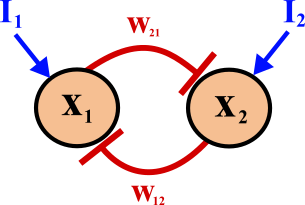

The red lines represent an inhibition (i.e. negative evidence) and blue lines represent positive evidence. Now, we want to write down the equations for the time evolution dynamics of the activity variables $x_1$ and $x_2$.



---


The model can be summarized as follows:

**Net input**

First, we need to compute the net input for each unit $x_i$:

$net_1 = - w_{12} x_2 + I_1 + \epsilon$

$net_2 = - w_{21} x_1 + I_2 + \epsilon$

with $\epsilon \sim N(0,\sigma)$

There are three components to the net input:

* *inhibition* from the competing task $-w_{ij}$,
* *external input* to the current task $I_i$,
* and Gaussian noise with 0 mean and standard deviation $\sigma$.

Let's assume unit values for the inhibition weights, $w_{12} = w_{21} = 1$. The noise may either be caused by external noise (e.g., acoustic noise in the environment) or internal noise (e.g., neural noise).

**Activity**

The activity dynamics of the model are determined as follows:

$\frac{dx_1}{dt} = - x_1 + S(g, net_1)$

$\frac{dx_2}{dt} = - x_2 + S(g, net_2)$

There are two components to the activity dynamics:

* *linear decay* of the current activity $-x_i$, and
* *non-linear integration* of the net input $S(g, net_i)$.

That is, there is a decay component for each unit, followed by the saturation function of the net input. Later on, we will investigate the effects of $g$ on the model dynamics.

--------

### <font color="red">**Exercise 2b** (1 point)</font>

<font color="red"> Your task is to implement this dynamical systems model below. You may make use of the function ``S(g, net)`` defined above. To add noise, you can use ``sigma * np.random.normal()``.</font>

In [14]:
def attractor_model(t, x, g, input, sigma):
  """ Dynamical model

  ------
  t: scalar time (you can ignore this variable)
  x: array [x1,x2] of activities of the neural units corresponding to tasks 1,2
  g: gain
  input: array[I1,I2] of input to neural units
  sigma: standard deviation of Gaussian noise added to the net input

  w_{12} = w{21} = 1

  Output
  -------
  dx1/dt(t,x)
  dx2/dt(t,x)

  """
  # split input I1 is for task 1 and I2 for task 2
  I1, I2 = input

  # inhibitory weights
  w1_2=1
  w2_1=1

  # initial conditions
  x1 = x[0]
  x2 = x[1]

  ###Exercise 1.c START###

  net_1 = -w1_2*x2 + I1 + sigma * np.random.normal()
  net_2 = -w2_1*x1 + I2 + sigma * np.random.normal()

  dx1_dt = -x1 + S(g, net_1)
  dx2_dt = -x2 + S(g, net_2)

  ###Exercise 1.c END###

  return np.array([dx1_dt, dx2_dt])

# If you are not sure you correctly solved the exercise uncomment the line below
# attractor_model = problemset4.attractor_model

Now we are ready to simulate some time trajectories!

One of the basic things we can now do with our model is integrating the ODE numerically to compute the time trajectory  𝑥(𝑡) .

In the code block below, we use the function ``solve_ivp``   to integrate our differential equation defined in ``simulate_dynamics``. (*solve_ivp* runs an explicit Runge-Kutta method which works well for most problems)

Note: to carry out the numerical integration, it is necessary to select a specific set of initial conditions `x_0 = np.array([x1_0, x2_0])` (initial neurons activity level) and define the simulation time interval T.

In [15]:
# execute this code block

def simulate_dynamics(T, g, input, sigma, x_0):
  # Integrate differential equation

  x_out = solve_ivp(attractor_model,
                    np.array([0,T]),
                    x_0,                # initial condition
                    dense_output=True,  # dense_output = True allows us to compute x at any time points on the interval T
                    args = [g, input, sigma]) # pass additional arguments to the simulation functon

  return x_out

For `solve_ivp` we then need a function to extract the values of the simulation at the desired time grid:

In [16]:
def extract_sim_values(T, x_out):

    ts = np.linspace(0,T,100) # list of 100 evenly spaced points in the time interval we are considering
    xt = x_out.sol(ts)                # solution of the integral at the specified time points
    x1 = xt[0,:]                      # the values of x1(t) are in the first column of the matrix xt
    x2 = xt[1,:]                      # the values of x2(t) are in the second column of the matrix xt

    return ts, x1, x2

Lastly, we want a function to plot the trajectory of the two variables as a function of time.

In [17]:
def plot_trajectory(T, ts, x1, x2, num_trials=1, ax=None):
    # Get the current figure
    fig = plt.gcf()
    fig.clf()  # Clear the figure to prevent overplotting
    if ax:
      ax.plot(ts,x1,label='x1')        # this plots the time trajectory of x1
      ax.plot(ts,x2,label='x2')        # this plots the time trajectory of x2
      ax.legend()                      # show the legend
      ax.set_xlabel('t')                   # this labels the horizontal axis
      ax.set_ylabel('activity (value of x_i)')                   # this labels the vertical axis
      ax.set_ylim([0, 1.0])
    # Add an axis if not provided
    if ax is None:
        ax = fig.add_subplot(111)

    # Plot the trajectories
    ax.plot(ts, x1, label='x1')  # Time trajectory of x1
    ax.plot(ts, x2, label='x2')  # Time trajectory of x2
    ax.legend()  # Show the legend
    ax.set_xlabel('t')  # Label the horizontal axis
    ax.set_ylabel('activity (value of x_i)')  # Label the vertical axis
    ax.set_ylim([0, 1.0])  # Set the y-axis limits

    # Add vertical lines for trials
    for trial_number in range(num_trials):
        trial_number += 1
        ax.axvline(T * trial_number, color='gray', linestyle='--')
    plt.draw()  # Ensure the updated plot is rendered
    plt.pause(0.001)  # Pause to allow the plot to update


To get familiar with the dynamics of the model try changing the task of the trial through `I1` and `I2`, as well as `sigma` and `T`in the code. Then change them back to their prior values (I1 = 1, I2 = 0, sigma = 0.4, T = 2) and try changing `g`, `x1_0` and `x2_0` through the sliders
 .


### <font color="red">**Exercise 2c** (1 point)</font>
<font color="red">

In the current scenario the participant is cued to react to task 1:

<font color="red"> Select what happens if you change $g$ from $0.5$ to $4$? Select the answer letters that apply (A, B, C, ...). Multiple answers are possible. (0.5 points) </font>

- A: The system increases attention to the cued task.
- B: The system decreases attention to cued task.
- C: The system increases attention to the uncued task.
- D: The system decreases atention to uncued task.
- E: For $g=4$, the system settles into an attractor. The attractor *depends on* the initial condition $(x_{1}(0),~x_{2}(0))$.
- F: For $g=4$, the system settles into an attractor. The attractor *does not depend* on the initial condition $(x_{1}(0),~x_{2}(0))$.

<font color="red"> Place your answers (just the letters) in the code block below the following code block.</font>

In [18]:
# important: for the task, parameters should be set back to their prior values!

def interactive_plot(g, x1_0, x2_0):

    I1 = 1       # Input to task 1 (prior value: 1)
    I2 = 0       # Input to task 2 (prior value: 0)
    sigma = 0.4   # noise (prior value: 0.4)
    T = 8 # Simulation time (prior value: 8)

    x_0 = [x1_0, x2_0]

    input = [I1, I2]
    np.random.seed(0)

    # Run the simulation
    x_out = simulate_dynamics(T, g, input, sigma, x_0)
    ts, x1, x2 = extract_sim_values(T, x_out)

    # Plot the trajectory
    plot_trajectory(T, ts, x1, x2)

# Create interactive sliders
g_slider = widgets.FloatSlider(value=0.5, min=0.0, max=10.0, step=0.5, description="Gain (g):")
x1_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x1_0:")
x2_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x2_0:")

# Use the interact function to create the interactive plot
interact(interactive_plot, g=g_slider, x1_0=x1_0_slider, x2_0=x2_0_slider)

interactive(children=(FloatSlider(value=0.5, description='Gain (g):', max=10.0, step=0.5), FloatSlider(value=0…

<function __main__.interactive_plot(g, x1_0, x2_0)>

In [19]:
# Edit this variable to provide your answer
answer_2_c = "ADF"



---



Two other important concepts in studying dynamical systems models are the phase space and the equilibrium solution:

 The **phase space** is the collection of all possible values the system state could take on. In the previous exercise we built a model and visualized its trajectories as a function of time. Alternatively, we can visualize these time trajectories as a path our system traces through phase space.

 **Equilibria** of a dynamical systems are solutions that do not change with time. This means that if the system's initial condition starts at an equilibrium, it will remain there forever. Mathematically this means that the rate of change at an equilibrium is zero, or  𝑑𝑥𝑑𝑡=0 .

One option to visualize the phase space would be to plot a **vector field**: at each point on the $(x_1,x_2)$ grid we can draw an arrow whose magnitude and direction are determined by the rates of change $(\frac{dx_1}{dt}, \frac{dx_2}{dt})$. This can be accomplished using the quiver function. One benefit of plotting a vector field is that it contains some information about time dependence (the length of each arrow represents the "speed" of the simulation at each point). However, it can be difficult to see what's going on near equilibria, and it can take some tuning of the plotting parameters to get a nice visualization.

Alternatively we can use the streamplot function to visualize the **streamlines** or trajectories of the flow - in this type of plot we will see the directionality of time, but we don't get a sense for how long the system will spend there.

Execute the code block below to generate both plots:


In [20]:
def compute_dx_dt(x_i, x_j, g, I, sigma):
  """ Activation Difference Function

  ------
  x_i: activity of the neural unit x_i corresponding to task 1 or task 2
  x_j: activity of the other neural unit x_i corresponding to task 2 or task 1
  g: gain
  I: input to the neural unit x_i
  sigma: standard deviation of Gaussian noise added to the net input

  Output
  -------
  dxi/dt
  """

  dx_dt = - x_i + S(g, -1 * x_j + I + sigma * np.random.normal())

  return dx_dt

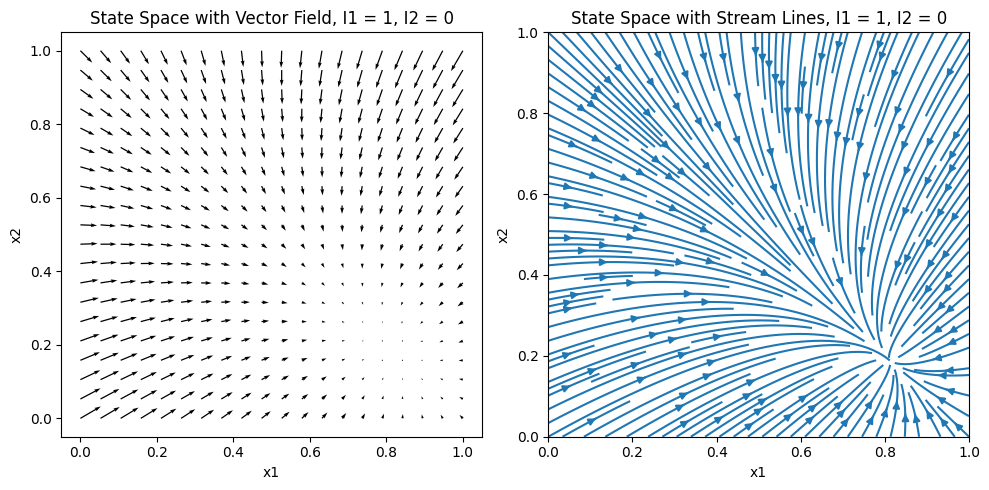

In [21]:
# YOU MAY TWEAK THIS PARAMETER
g = 1.8    # Gain parameter (you may tweak this for the exercise)

# KEEP THESE PARAMETERS FIXED
I1 = 1       # Input to task 1 (you may change this for the exercise)
I2 = 0        # Input to task 2 (you may change this for the exercise)
sigma = 0     # noise (keep this fixed)

x1_vals = np.linspace(0,1,20)             # 1d grid: horizontal coordinates
x2_vals = np.linspace(0,1,20)             # 1d grid: vertical coordinates

X1, X2 = np.meshgrid(x1_vals, x2_vals)      # 2D coordinate grids

# for each point in the state space, we compute the change in activity and plot this as a vector
U = compute_dx_dt(X1, X2, g, I1, sigma)
V = compute_dx_dt(X2, X1, g, I2, sigma)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axs[0].quiver(X1,X2,U,V)                    # generate a vector field
axs[0].set_title('State Space with Vector Field, I1 = '+str(I1)+', I2 = '+str(I2))
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].streamplot(X1,X2,U,V,density = 2)        # generate streamlines for system trajectories
axs[1].set_title('State Space with Stream Lines, I1 = '+str(I1)+', I2 = '+str(I2))
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')

plt.tight_layout()
plt.show()

### <font color="red">Exercise 2d  (1point)</font>

<font color="red"> Now it's your turn to play around with the model. Find a value for $g$ , $I1$ and $I2$ that fits the following time trajectory and shortly explain why:   </font>

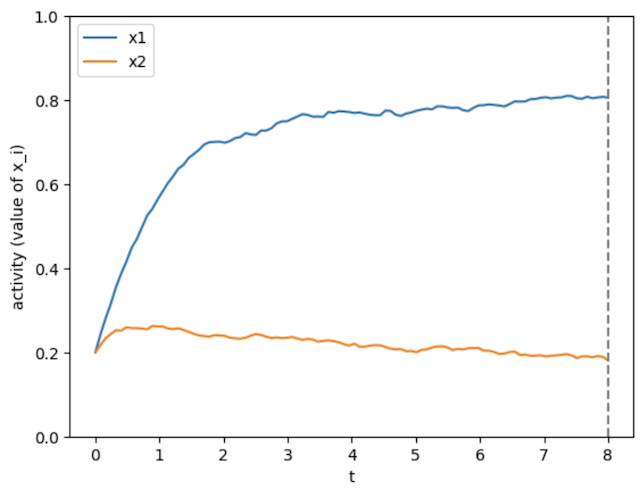



In [22]:
# Edit this variable to provide your answer
answer_2_d = "g=1.8 I1=1 I2=0 Fit the time trajectory well. Because at around x1=0.8 and x2=0.2 we can see the vectore field reaching a equilibrium. We can see a similar equlibirum for x1=0.8 and x2=0.2 in the time diagram. Which indicates that they have the same parameters."


## <font color="red"> Exercise 3: Simulate surrogate experimental data from the model  (4 points)</font>


Until now our model is able allocate focus to one of the tasks depending on the input. However, our model still needs to decide depending on this task. Since humans make mistakes in this experiment, and choose to react to the wrong task, although in theory they should be able to choose correctly, there needs to be some probability for our model to choose wronlgy too. To achieve this, we will use the softmax function, which you already know from the first problem set adjusted to this experiment:

\begin{align}
P(Task_{i,t}) = \frac{e^{A_{i,t} \beta(t)}}{e^{A_{1,t} \beta(t)} + e^{A_{2,t} \beta(t)}}
\end{align}

where


*   $P(Task_{i,t})$ is the probability of choosing $Task_{i,t}$ in the current trial,
*   $A_{1,t}$ is the final level activity of neuron 1 (at the time end point of that trial), representing task 1
*   $A_{2,t}$ is the final level activity of neuron 2, representing task 2
*   $\beta(t)$ determines the "softness" of the choice (lower values -> more exploration) and varies across trials $t$.

as a small fresh up:

Changes in the "noisyness" of the choice process are expressed as follows:


\begin{align}
\beta(t) = \left(\frac{t}{10}\right)^c
\end{align}

for trial $t$ where <font color="purple">$c$ is the third parameter</font>, regulating whether whether the decision gets more noisy over time ($c < 0$), stays as noisy ($c = 0$), or gets less noisy over time ($c > 0$). To avoid numerical instabilities, we will bound $-2 < c < 2$.

Now you need to execute a few code cells:

In [23]:
def compute_choice_probabilities(activities_n_final, trial_number, c): # c > 0 -> choice gets less noise over time -> better!
  '''
  This function computes the choice probabilities for each deck based on the
  current expectancies

  Input arguments:
    neuron_activities: a list of both neuron activities
    trial_number: number of the current trial
    c: parameter used to compute beta
    switch_trial: bool if the task in the current trial switched from the preceding trial
  '''

  # compute beta
  beta = pow((trial_number+1)/10, c)

  #scaling factor (small differences between neuron activities are magnified, which makes the exponential terms more distinct)
  alpha = 3

  # compute softmaxed choice proabbilities
  choice_probs = np.exp(activities_n_final * alpha * beta) / np.sum(np.exp(activities_n_final * alpha * beta))

  return choice_probs


def compute_choice(activities_n_final, trial_number, c):
  '''
  This function computes the index of the chosen deck for the next trial

  Input arguments:
    expectancies: a list of expectancies for all four decks
    trial_number: number of the current trial
    c: parameter used to compute beta
  '''

  # compute softmaxed choice proabbilities
  choice_probs = compute_choice_probabilities(activities_n_final, trial_number, c)

  # compute cumulated sums
  cumulated_choice_probs = np.cumsum(choice_probs)

  # draw random number between 0 and 1
  random_number = random.random()

  # choose deck index depending on choice probabilities
  index = 0

  # Iterate through the cumulative sums to find the first index where the random number exceeds the cumulative sum
  while index < len(cumulated_choice_probs) and random_number > cumulated_choice_probs[index]:
      index += 1

  return index


Further we need some functions to implement the properties of the experiment such as the trial type (switch or no switch) and task type (upper row -> letter or lower row -> number).

In [24]:
def test_trial_type(current_task, former_task):

  if current_task == former_task:
    trial_type = 'no_switch'
  else:
    trial_type = 'switch'

  return trial_type

In [25]:
def initialize_task():

  task = random.randint(0, 1)

  if task == 0:
    I1 = 1
    I2 = 0
    current_task = "letter"

  else:
    I1 = 0
    I2 = 1
    current_task = "number"

  input = np.array([I1,I2])

  return current_task, input

Also, to log the results, we want to have afunction which tells us if the choice was correct.

In [26]:
def get_correctness(input, choice):

  if input[choice] == 1:
    correctness = True
  else:
    correctness = False

  return correctness

In [27]:
def log_data(df, trial_number, activities_n_final, current_task, trial_type, choice, correctness):
  '''
  This function logs several outcomes of the simulation into a data frame.

  Input arguments:
    df: a Pandas dataframe in which we write the data
    trial_index: current trial number
    activities_n_final: activity of neuron 1 (letter task) and neuron 2 (number task) at the end of trial
    task: letter or number task
    trial_type: whether the task switched from the trial before (switch) or stayed the same (no_switch)
    choice: chosen task to react to 0 -> letter task , 1 -> number task
    correctness: whether the chosen task is correct
  '''

  new_row = pd.DataFrame(
            {'trial_index': trial_number,
             'activity_n1': activities_n_final[0],
             'activity_n2': activities_n_final[1],
             'task': current_task,
             'trial_type': trial_type,
             'choice': choice,
             'correctness': correctness}, index=[0])

  df = pd.concat([df, new_row], axis=0, ignore_index=True)
  return df

Lastly, we have our function to simulate the experiment with our dynamical system model. You can also plot the corresponding trajectory, if the number of trials is not too high

### <font color="red">**Exercise 3a** (1 point)</font>

<font color="red"> Your task is to finish the function below.

<font color="red">1) Implement  `choice` (use the functions from above). (0.5)

2) Since we want to simulate several trials, you need to set the initial values of the individual simulation. Implement how to define `x_1`and `x_2`. (0.5)
</font>

In [28]:
def simulate_experiment(num_trials, T, g, sigma, c = 0, bool_plot_trajectory = False):

  # we will log the entire simulation in a dataframe
  df = pd.DataFrame(columns=['trial_index', 'activity_n1', 'activity_n2', 'task', 'trial_type', 'choice', 'correctness'])

  # set initial neuron activity

  x_1 = 0.5
  x_2 = 0.5


  # create arrays for plotting
  array_x1 = []
  array_x2 = []
  array_ts = []

  for trial_number in range(num_trials): # starts with 0

    x_0 = np.array([x_1, x_2])

    current_task, input = initialize_task() # wether task is letter or number, input -> [I1,I2]

    if trial_number > 0:
      trial_type = test_trial_type(current_task, df['task'].iloc[-1]) # wether type is switch or no_switch

    else: #for first trial since there is no former task
      trial_type = None


    x_out = simulate_dynamics(T, g, input, sigma, x_0) # run model i.e. solve OED

    ts_values, x1_values, x2_values = extract_sim_values(T, x_out)

    activities_n_final = np.array([x1_values[-1], x2_values[-1]]) # get last values of neuron activity


    #### complete this code part  ####

    choice = compute_choice(activities_n_final, trial_number, c)
    x_1 = x1_values[-1]
    x_2 = x2_values[-1]

    ###################

    correctness = get_correctness(input, choice)

    # log results
    df = log_data(df, trial_number, activities_n_final, current_task, trial_type, (choice + 1), correctness)

    ###########################################################
    ###### plotting part beginns -> do not change anything ####
    ###########################################################

    if bool_plot_trajectory == True:

      if num_trials == 1:

        array_x1 = x2_values
        array_x2 = x1_values
        array_ts = ts_values

      elif num_trials <= 9:

        array_x1 = np.concatenate((array_x1, x1_values), axis=None)
        array_x2 = np.concatenate((array_x2, x2_values), axis=None)
        array_ts = np.concatenate((array_ts, ts_values + ( T * (trial_number ))), axis=None)

  if (bool_plot_trajectory == True) & (num_trials <= 9):
    plot_trajectory(T, array_ts, array_x1, array_x2, num_trials)
  elif (bool_plot_trajectory == True) & (num_trials > 9):
    print ('no plot possible, too many trials')
  ##############################
  ##### plotting part ends######
  ##############################


  return df

# If you are not sure you correctly solved the exercise uncomment the line below
# simulate_experiment = problemset4.simulate_experiment


Now finally, lets simulate some experiment data!

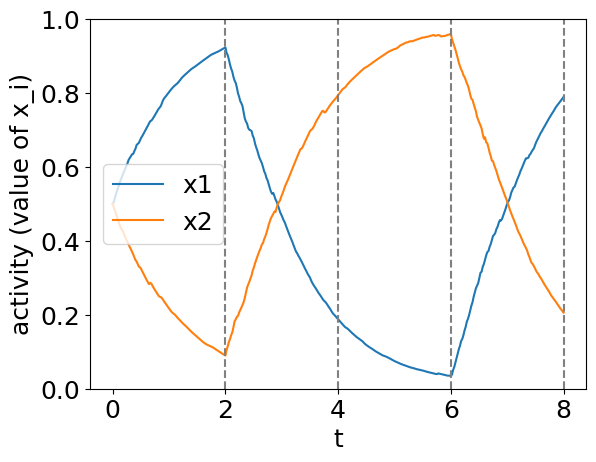

  trial_index  activity_n1  activity_n2    task trial_type choice correctness
0           0     0.923320     0.089746  letter       None      1        True
1           1     0.187865     0.794258  number     switch      2        True
2           2     0.034512     0.959425  number  no_switch      2        True
3           3     0.789763     0.205749  letter     switch      1        True


In [61]:
random.seed(2)
num_trials = 4
T = 2
g = 6
c = 0.1
sigma = 0.3

df = simulate_experiment(num_trials, T, g, sigma, bool_plot_trajectory = True)
print(df)

### <font color="red"> **Exercise 3b** (1 point)</font>


<font color="red">1) Take a look at the plot above. The dashed lines indicate that a new trial and simulation run started. State, for each of the 4 trials, the trial type (repeat or switch or neither). (0.5)


In [30]:
# Edit this variable to provide your answer
answer_3_b_1 = "trial1: neither, trial2: switch, trial3: repeat, trial4: switch"

<font color="red">2) Explain how the dynamics of the neurons activities during a switch trial lead to lower accuracy than in a no switch trial. (Hint: trial 3 and 4 are nice examples) (0.5)

In [31]:
# Edit this variable to provide your answer
answer_3_b_2 = "If a trial is a repeat trial, then the model is already close to a given state from the previous trial of the given task, which leads to a quick and accurate descion. On switching tasks, the model first needs to find a new equlibrium, which takes some time. Thus the model might be to slow to answer accuratly in time."

Now we will simulate a larger data set with two different values for parameters of g. Take a look at the data to get a feeling for the structure of the dataframe:

In [32]:
num_trials = 100
T = 2

g_1 = 2
g_2 = 6

c = 0.1

sigma = 0

df_1= simulate_experiment(num_trials, T, g_1, sigma)
df_2= simulate_experiment(num_trials, T, g_2, sigma)

print(df_1)
print(df_2)

   trial_index  activity_n1  activity_n2    task trial_type choice correctness
0            0     0.759433     0.240567  letter       None      2       False
1            1     0.312881     0.687119  number     switch      2        True
2            2     0.193128     0.806872  number  no_switch      2        True
3            3     0.164637     0.835363  number  no_switch      2        True
4            4     0.664468     0.335532  letter     switch      2       False
..         ...          ...          ...     ...        ...    ...         ...
95          95     0.189951     0.810049  number  no_switch      2        True
96          96     0.163900     0.836100  number  no_switch      1       False
97          97     0.157871     0.842129  number  no_switch      2        True
98          98     0.662418     0.337582  letter     switch      2       False
99          99     0.800821     0.199179  letter  no_switch      1        True

[100 rows x 7 columns]
   trial_index  activity_n1 

 In the next part we want to examine whether our model can recreate the switch cost of lower accuracy in the switch condition and what role g plays in that.  

### <font color="red">**Exercise 3c** (2 points)</font>

<font color="red"> 1) Fill in the missing part of the code to calculate the switch cost. (1 point)

**Hint**: Switch cost refers to a performance cost invoked by switching from one task to another (versus repeating a task). Think about which columns in the dataset differ on **switch trials** and **no-switch trials**.



In [33]:
def calculate_switch_cost(df):

  x = "trial_type"
  y = "correctness"

  # Group by 'trial_type' and calculate the mean of 'correctness'
  mean_correctness = df.groupby(x)[y].mean()

  return mean_correctness


<font color="red"> 2) Explain how g influences the models ability to recreate a switch cost. (1 point)

In [34]:
print("df_1:",calculate_switch_cost(df_1))
print()
print("df_2:",calculate_switch_cost(df_2))

df_1: trial_type
no_switch    0.929825
switch       0.714286
Name: correctness, dtype: object

df_2: trial_type
no_switch    0.909091
switch       0.977273
Name: correctness, dtype: object


In [35]:
# Edit this variable to provide your answer
answer_3_c = "With higher g, the model appears to have an overall higher accuracy and a lower switch cost (difference between switch and no_switch). This could be because a higher g leads to faster convergence and may thus offset the switch cost by quickly settling into an equilibrium for the new task. So, a lower g is better for modeling a high switch cost."

---
Now to the last part of the dynamical systems section: **Parameter fitting and recovery**

Here we will use a similar log likelihood function as in problem set 1. We will also fit and try recovering the parameters through grid search.

Run the code cells below and take a close look at the outputs:

In [36]:
def compute_log_likelihood(df, x_0,  g, sigma, c):
  '''
  This function computes the log likelihood for a given set of model parameters

  Input arguments:
    df: data frame
    W: the valence parameter
    alpha: the update parameter
    c: parameter used to compute the softmax parameter beta
  '''
  # initialize log likelihood
  LL = 0
  num_trials = len(df)

  for trial_number in range(num_trials):

    # when computing the likelihood, we don't need to make a choice
    # instead, we observe the choice from the data
    choice = df['choice'][trial_number] - 1

    # get input from df for current trial
    if df['task'][trial_number] == "letter":

      input = np.array([1,0])
    else:
      input = np.array([0,1])

    x_out = simulate_dynamics(T, g, input, sigma, x_0) # run model i.e. solve OED

    _, x1_values, x2_values = extract_sim_values(T, x_out)

    activities_n_final = np.array([x1_values[-1], x2_values[-1]])

    choice_probabilities = compute_choice_probabilities(activities_n_final, trial_number, c) # YOUR ANSWER GOES HERE

    LL = LL + np.log(choice_probabilities[choice]) # YOUR ANSWER GOES HERE

    # update x_0
    x_0 = activities_n_final

  return LL

best_LL: -22.478915353054592
best_c: 0.0
best_g: 3.5


Text(0, 0.5, 'g')

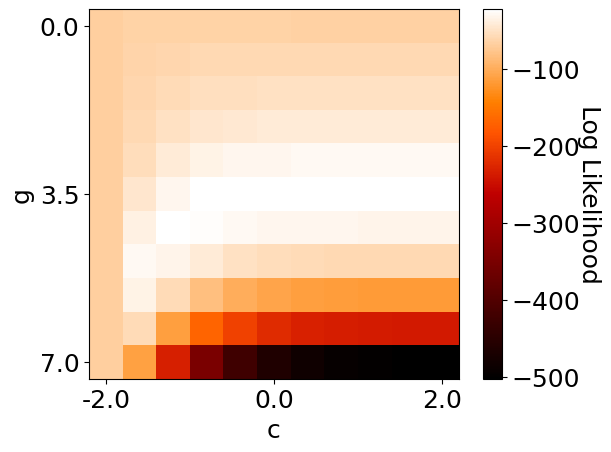

In [37]:
random.seed(2)
# experiment parameters
num_trials = 100
x_0 = np.array([0.5,0.5])

# model parameters
T = 5
sigma = 0

true_g = 3
true_c = 0.1

plt.rcParams.update({'font.size': 18, 'font.family': "sans-serif"}) # 'font.weight': 'bold'

# search space over parameters T and g (sigma and c are assumed to be known)
c_values = np.linspace(-2, 2, 11)
g_values = np.linspace(0, 7, 11)

# obtain surrogate data by simulating the model
df = simulate_experiment(num_trials, T, true_g, sigma, true_c)

# we will store our log likelihoods in this matrix
LL_matrix = np.zeros((len(c_values), len(g_values)))

best_LL = -10000
best_c = 0
best_g = 0

# loop through each parameter combination (grid search)
for c_idx, c in enumerate(c_values):
  for g_idx, g in enumerate(g_values):

    # compute log likelihood
    LL = compute_log_likelihood(df, x_0,  g, sigma, c)

    # store log likelihood in the data matrix
    LL_matrix[c_idx, g_idx] = LL

    if LL > best_LL:
      best_c = c
      best_g = g
      best_LL = LL

print("best_LL:", best_LL)
print("best_c:", best_c)
print("best_g:", best_g)

# Create a heatmap of the data matrix
plt.imshow(LL_matrix, cmap='gist_heat')

# Add a colorbar to the plot
cbar = plt.colorbar()
cbar.set_label('Log Likelihood', rotation=270, labelpad=15)

# Set custom tick labels for the X and Y axes
x_ticks = c_values
y_ticks = g_values
visible_ticks_x = [x_ticks[0], x_ticks[len(x_ticks) // 2], x_ticks[-1]]
visible_ticks_y = [y_ticks[0], y_ticks[len(y_ticks) // 2], y_ticks[-1]]

# Set the positions and labels for the visible ticks
plt.xticks([0, len(x_ticks) // 2, len(x_ticks) - 1], visible_ticks_x)
plt.yticks([0, len(y_ticks) // 2, len(y_ticks) - 1], visible_ticks_y)

# Add labels to the axes
plt.xlabel('c', fontsize=18)
plt.ylabel('g', fontsize=18)

Completed run 0 of 10
Completed run 1 of 10
Completed run 2 of 10
Completed run 3 of 10
Completed run 4 of 10
Completed run 5 of 10
Completed run 6 of 10
Completed run 7 of 10
Completed run 8 of 10
Completed run 9 of 10
Pearson correlation coefficient for c: 0.945645717002198
Pearson correlation coefficient for g: 0.8560587969406502


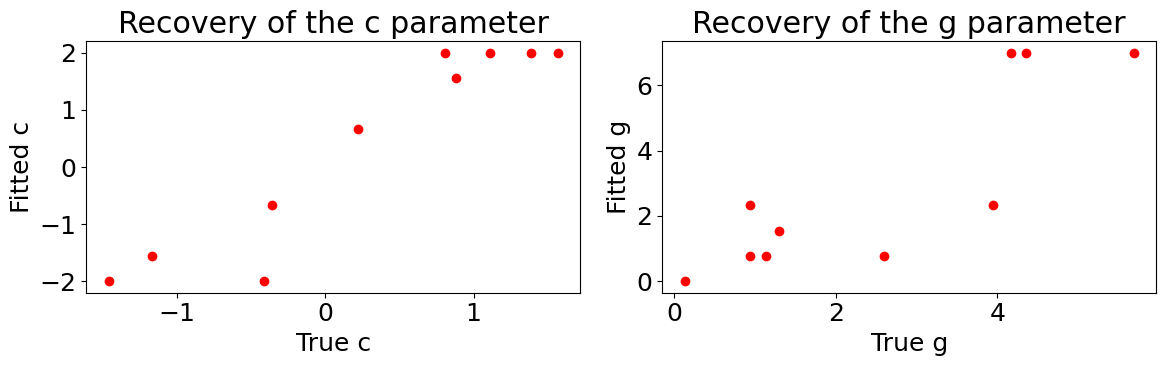

In [38]:
random.seed(1) # DON'T REMOVE THIS LINE

num_trials = 100
T = 5
sigma = 0
x_0 = np.array([0.5,0.5])

# the number of true values we seek to simulate
num_true_values = 10

# range of simulated and tested values for c
min_c = -2
max_c = 2

# range of simulated and tested values for g
min_g = 0
max_g = 7

# determine range of parameters for fitting
c_values = np.linspace(min_c, max_c, 10)

g_values = np.linspace(min_g, max_g, 10)

# create some arrays for logging
true_g_log = np.zeros(num_true_values)
true_c_log = np.zeros(num_true_values)


fitted_g_log = np.zeros(num_true_values)
fitted_c_log = np.zeros(num_true_values)


# for each run, we will simulate data with randomly sampled parameters and
# then attempt to fit those data.
for run in range(num_true_values):
  print("Completed run " + str(run) + " of " + str(num_true_values))

  # randomly sample model parameters from which to sample surrogate data
  true_g = random.uniform(min_g, max_g)
  true_c = random.uniform(min_c, max_c)

  # log those parameters
  true_g_log[run] = true_g
  true_c_log[run] = true_c

  # simulate surrogate data
  df = simulate_experiment(num_trials, T, true_g, sigma, true_c )

  # initialize the simulation with a very low LL (indicating bad fit)
  # and some initial parameters
  best_LL = -10000
  best_c = 0
  best_g = 0

  # loop through each parameter combination (grid search)
  for c_idx, c in enumerate(c_values):
    for g_idx, g in enumerate(g_values):

      # compute log likelihood
      LL = compute_log_likelihood(df, x_0,  g, sigma, c)

      # store log likelihood if it is higher than the previous one
      if LL > best_LL:
        best_c = c
        best_g = g
        best_LL = LL

  # store the parameter combination yielding the highest log likelihood
  fitted_g_log[run] = best_g
  fitted_c_log[run] = best_c


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize as needed

# Create the first scatter plot on the left
ax1.scatter(true_c_log, fitted_c_log, marker='o', color='red')
ax1.set_xlabel('True c')
ax1.set_ylabel('Fitted c')
ax1.set_title('Recovery of the c parameter')

# Create the second scatter plot on the right
ax2.scatter(true_g_log, fitted_g_log, marker='o', color='red')
ax2.set_xlabel('True g')
ax2.set_ylabel('Fitted g')
ax2.set_title('Recovery of the g parameter')

# Adjust spacing between subplots
plt.tight_layout()

# Compute the Pearson correlation coefficient for c
correlation_matrix = np.corrcoef(true_c_log, fitted_c_log)
# The correlation coefficient is at (0, 1) in the correlation matrix
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation coefficient for c: {correlation}")

# Compute the Pearson correlation coefficient for W
correlation_matrix = np.corrcoef(true_g_log, fitted_g_log)
# The correlation coefficient is at (0, 1) in the correlation matrix
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation coefficient for g: {correlation}")

When modeling, you may find that some parameters are harder to recover than others. While it can be challenging to determine exactly why this happens, developing hypotheses about such phenomena is a valuable skill for modelers. In the parameter recovery plot above, we observe this challenge in our model: the parameter $g$.

$g$ appears to be less recoverable than $c$.

Understanding why certain parameters are less identifiable can guide improvements in model design or experimental setup, ensuring more reliable inferences.

So now it is your turn!

### <font color="red">**Exercise 3d** (1 point)</font>

<font color="red"> Hypothesize why $g$ might be harder to recover than $c$. (Your answer does not have to be perfect, just try to come up with a hypothesis based on your gained knowledge of parameter $g$)

In [39]:
# Edit this variable to provide your answer
answer_3_d = "It is harder to recover g because its effect is not fixed but rather probabilistic. This means that a model with a high g might still fail to adapt to a switch. Looking at the sigmoid function from earlier, one can see that it changes only slightly for low g values and lacks the clear and quick convergence of higher g values, making it hard to distinguish between similar levels of low g."

(credits to Anastasia Bizyaeva, University of Washington, for the Dynamical Systems Part)

#**Part III: Sequential Sampling Modeling**

### Motivation for Using the Drift Diffusion Model (DDM) in Task-Switching
Task switching presents unique challenges in cognitive research, as small variations in task parameters can significantly influence behavior. *Hoffing et al. (2018)* emphasized these complexities and suggested that computational models, like the Drift Diffusion Model (DDM), could offer deeper insights into the decision-making processes involved in task switching.

The DDM, first introduced by Ratcliff (1978), is a robust framework for modeling decision-making. It breaks down the process into key components—such as decision biases, information accumulation rates, and decision boundaries—allowing for a detailed analysis of cognitive mechanisms. Unlike traditional models, the DDM simultaneously accounts for both reaction time (RT) and accuracy, providing a comprehensive view of performance.
By partially replicating *Hoffing et al. (2018)* study with the DDM, we aim to explore how task-switching affects the model's parameters.To better understand why the Drift Diffusion Model is effective for task-switching studies, let’s explore how the model works and its key components in detail.

### An Overview of the Drift Diffusion Model (DDM)

The Drift Diffusion Model (DDM) assumes that decision-making is a process of evidence accumulation. This can be represented as a random walk, where the accumulated evidence ($W(t)$) changes over time according to the equation:

$$ W(t + dt) = W(t) + v \cdot dt + n $$

Where:
- **$W(t)$** is the accumulated evidence at time $t$,
- **$v$** is the mean drift rate,
- **$dt$** is the time step, and
- **$n$** represents random noise.

The process **stops** once the accumulated evidence reaches one of the decision thresholds.

### Key Components of the DDM:
- **Drift Rate ($v$)**: This reflects the rate at which evidence is accumulated. A high drift rate leads to faster and more accurate decisions, while a low drift rate results in slower, potentially less accurate decisions. In task-switching, the drift rate can be influenced by factors such as task difficulty, working memory capacity, and task-set biasing *(Schmitz & Voss, 2012; Schmiedek et al., 2007)*.
  
- **Decision Boundary ($a$)**: The decision boundary represents the amount of evidence required to make a decision. A wider boundary results in  more careful decisions, leading to slower response times but potentially higher accuracy. This captures the speed-accuracy trade-off. In task-switching, the boundary can vary, being larger for switch trials (indicating more caution) and smaller for repeat trials (indicating less caution) *(Karayanidis et al., 2009; Schmiedek et al., 2007)*.

- **Non-decision Time ($t_0$)**: This represents processes such as stimulus encoding, task-set preparation, and motor execution. Non-decision time is typically assumed to be constant across switch and non-switch trials when the cue-stimulus interval is sufficiently long *(Madden et al., 2009; Ratcliff & McKoon, 2008)*.

### How the DDM Works:
Below is a simple diagram illustrating how the DDM works in the context of task-switching.
<img src="https://www.researchgate.net/publication/329577163/figure/fig2/AS:703345597640704@1544702066294/Illustration-of-a-drift-diffusion-model-DDM-to-model-reaction-times-in-two-choice.ppm" width=700></img>

The evidence accumulates over time until it reaches one of the thresholds. Reaching **0** corresponds to an **incorrect response**, and reaching **$a$** corresponds to a **correct response**.

In the diagram above:

- **Drift Rate ($v$)** : The slope of the evidence accumulation (blue and red lines) reflects the drift rate. A steeper slope indicates faster accumulation of evidence toward the upper boundary, resulting in quicker correct responses. The blue line represents correct responses, where evidence accumulates toward the upper boundary, while the red line shows incorrect responses, where evidence accumulates toward the lower boundary.

- **Decision Boundary ($a$)** : The upper and lower boundaries define the thresholds that evidence must reach to trigger a decision. Wider boundaries (greater vertical distance) allow for more cautious decisions with slower RTs but higher accuracy, while narrower boundaries result in faster decisions with potentially more errors.

- **Non-decision Time ($t_0$)** : The portion of the graph before the evidence accumulation begins reflects the non-decision time. This includes processes like stimulus encoding and motor execution, which occur before evidence accumulation starts.

- **Bias ($z$)** : The starting point of the accumulation process (marked as $z$ on the graph) reflects any pre-existing bias toward one decision threshold. A starting point closer to the upper boundary suggests a bias toward the correct response, while a starting point closer to the lower boundary indicates a bias toward errors.

- **Reaction Time Distributions** : The blue shaded region above the graph shows the distribution of reaction times for correct responses. These responses tend to have faster RTs due to efficient evidence accumulation (high drift rate).
The red shaded region below the graph shows the distribution of RTs for incorrect responses. Errors can occur either quickly (if noise causes the evidence to hit the wrong threshold early) or more slowly (due to inconsistent evidence accumulation).


### Implementing the DDM

Formally, the drift diffusion model can be implemented as a dynamical system where $x$ represents the accumulated evidence.The change in evidence ($dx$) at each time step is computed using the following equation:

<center>$dx = v \cdot dt + \sqrt{dt} \cdot \epsilon$</center>

where $\epsilon \sim N(0,\sigma)$

Let's break the model down:
- $dx$ is the change in evidence accumulation over a small time interval.
- $v$ is the rate of evidence accumulation
- $dt$ represents an infinitesimally small increment of time.
- $\sqrt{dt} \cdot \epsilon$ The stochastic (random) component of the process, modeled as a Wiener process (Brownian motion). Here:
  *  $\epsilon$ is a random variable drawn from a normal distribution with mean 0 and variance $\sigma^2$ scales the random noise to match the time step size( $\epsilon$ ~ *N*( 0, $\sigma^2$ )
  *  $\sqrt{dt} \cdot \epsilon$ scales random noise to match the time step size

Once the change $dx$ in evidence  is computed, we update the accumulated evidence $x$ as follows:
<center>$x(t+dt)=x(t)+dx$</center>

Furthermore, we assume that the evidence accumulation process stops if $x \leq 0$ (lower threshold is hit) or $x \geq a$ (upper threshold $a$ is hit).

## <font color="red">**Exercise 3: Implementing DDM** (1 point)</font>

<font color="red">Your task is to implement the Drift Diffusion Model (DDM) based on the formulas and explanation provided in the previous cell.To add noise, you can use ``sigma * np.random.normal()``

In [40]:
def run_ddm(drift_rate = 1,
            threshold = 1,
            starting_point = 0.5,
            noise_std = 1,
            non_decision_time = 0,
            dt = 0.01,
            max_time = 200):
    """
    Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Parameters are the same as the previous function.

    Arguments:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
    """
    # Initialize evidence accumulation process
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    # Run the simulation until a decision boundary is reached or max time is exceeded
    while time < max_time:
        #Compute change in evidence
        #Update evidence based on change
        dx = drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal()
        evidence += dx

        evidence_over_time.append(evidence)
        time += dt  # Increment the time

        # Check if the evidence has reached either threshold
        if evidence >= threshold:
            return time, evidence_over_time, 1  # Decision made for the upper threshold
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Decision made for the lower threshold

    # If no decision has been made by max_time, return the current state
    return time, evidence_over_time, 0
# If you are not sure you correctly solved the exercise uncomment the line below
# run_ddm = problemset4.run_ddm

You may execute the code block below to visualize your DDM and inspect it by changing parameters

In [41]:
# Interactive plotting function
def plot_interactive_ddm(v, a, z):
    # Set fixed values for the other parameters
    sigma = 1       # Noise standard deviation (fixed)
    t0 = 0          # Non-decision time (fixed)
    dt = 0.01       # Time step (fixed)
    max_time = 1000 # Maximum simulation time (fixed)

    # Run the simulation with the provided parameters
    decision_time, evidence_over_time, decision = run_ddm(drift_rate=v,
                                                          threshold=a,
                                                          starting_point=z,
                                                          noise_std=sigma,
                                                          non_decision_time=t0,
                                                          dt=dt,
                                                          max_time=max_time)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--', label='Upper Threshold (Correct)')
    plt.axhline(y=0, color='red', linestyle='--', label='Lower Threshold (Incorrect)')
    plt.xlabel('Reaction Time (s)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
    plt.legend()
    plt.show()

# Create sliders for interactive parameters
v_slider = widgets.FloatSlider(value=0.01, min=0, max=0.1, step=0.001, description="Drift Rate (v):")
a_slider = widgets.FloatSlider(value=2, min=1, max=5, step=0.1, description="Threshold (a):")
z_slider = widgets.FloatSlider(value=1, min=0, max=2.5, step=0.1, description="Starting Point (z):")

# Use interact to update the plot interactively
interact(plot_interactive_ddm, v=v_slider, a=a_slider, z=z_slider)

interactive(children=(FloatSlider(value=0.01, description='Drift Rate (v):', max=0.1, step=0.001), FloatSlider…

<function __main__.plot_interactive_ddm(v, a, z)>

## <font color="red"> **Exercise 4: Fitting DDM Parameters by Hand (1 point)**</font>

Next, we will use the DDM function to simulate reaction time distributions. To do so, we will run the DDM multiple times for the same parameter configuration. Doing so will give us many decision times for each boundary, that we will add up to a histogram.

You may execute the following code block to run the function for plotting the histogram:

In [62]:
### from previous
def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):
    """
    Helper function for plotting RT distribbutions as histograms.
    """

    # Calculate the weights for each group to normalize the histograms
    weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
    weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

    if rt_upper_empirical is not None and rt_lower_empirical is not None:
        weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
        weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

    # set up figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Plot the histograms for upper threshold
    axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
    if rt_upper_empirical is not None:
        axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
    axs[0].set_xlabel('Reaction Time (s)')
    axs[0].set_ylabel('Normalized Frequency')
    axs[0].legend()
    axs[1].set_ylim([0, y_max])
    axs[0].set_title('Correct Response Threshold')

    # Plot the histograms for lower threshold
    axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
    if rt_upper_empirical is not None:
        axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
    axs[1].set_xlabel('Reaction Time (s)')
    axs[1].set_ylabel('Normalized Frequency')
    axs[1].legend()
    axs[0].set_ylim([0, y_max])
    axs[1].set_title('Incorrect Response Threshold')

    # Adjust layout
    plt.tight_layout()

    # Display the figure
    plt.show()

In [63]:
def plot_interactive_ddm(v, a, z, t=0.2):
    # Define true parameters
    true_values_model1 = [v, a, z, t]

    # Simulate data
    simulated_data_1 = hssm.simulate_data(
        model="ddm",
        theta=true_values_model1,
        size=1000,
    )

    # Print number of correct/incorrect trials of simulated_data
    correct_df = simulated_data_1[simulated_data_1['response'] == 1]
    incorrect_df = simulated_data_1[simulated_data_1['response'] == -1]
    correct_rt = correct_df['rt']
    incorrect_rt = incorrect_df['rt']
    print(f"{len(correct_rt)} correct trials in simulated data, {len(incorrect_rt)} incorrect trials in simulated data.\n")
    #collect empirical data for histogram
    dataset = problemset4.get_simulated_histogram_data()
    filtered_rt_lower = dataset[dataset['response'] == -1]['rt']
    rt_lower_empirical = filtered_rt_lower.to_numpy()
    filtered_rt_upper = dataset[dataset['response'] == 1]['rt']
    rt_upper_empirical = filtered_rt_upper.to_numpy()
    print(f"{len(rt_upper_empirical)} correct trials in human data, {len(rt_lower_empirical)} incorrect trials in human data.\n")

    # Plot RT distributions for correct/incorrect trials
    plot_ddm_histograms(correct_rt, incorrect_rt,rt_upper_empirical,rt_lower_empirical)

# Create sliders for v, a, and z
v_slider = widgets.FloatSlider(value=0.5, min=-1.0, max=2.0, step=0.1, description="Drift Rate (v):")
a_slider = widgets.FloatSlider(value=1.5, min=1.0, max=3.0, step=0.1, description="Threshold (a):")
z_slider = widgets.FloatSlider(value=0.75, min=0.1, max=2.5, step=0.1, description="Starting Point (z):")
t_slider = widgets.FloatSlider(value=0.75, min=0.1, max=2.5, step=0.1, description="Non-decision trial(t):")
# Use interact to link the sliders to the function
interact(plot_interactive_ddm, v=v_slider, a=a_slider, z=z_slider,t=t_slider)

interactive(children=(FloatSlider(value=0.5, description='Drift Rate (v):', max=2.0, min=-1.0), FloatSlider(va…

<function __main__.plot_interactive_ddm(v, a, z, t=0.2)>

Drift Rate (v):
-0.50
Threshold (a):
1.10
Starting Point (z):
0.50
Non-decision trial(t):
0.50


###<font color="red">Exercise 4a:

Your task is to tune the parameters of the DDM above(change values) so that the empirical and simulated reaction time distributions match. Fitting the distribution will be eaiser if you have a basic understanding of what each parameter does. You don't have to produce an exact match but you should capture key features of the data that are determined by the DDM parameters.</font>

## <font color="red"> **Exercise 5: Fitting DDM via MCMC Sampling** (2 points)</font>

### Mini-Tutorial: Using the HSSM Toolbox

After the previous task, where you had to manually tune the parameters yourself, you might have realized how challenging it can be to find the right parameters. To our delight, the HSSM library we are using provides a function that automatically handles parameter tuning for us.

In the final exercise, you will be tasked with fitting a DDM to experimental data via MCMC sampling and performing a model comparison(bonus task).

For this exercise, we will make use of the [HSSM toolbox](https://github.com/lnccbrown/HSSM), which provides methods for formulating and fitting sequential sampling models, such as the DDM. You can read more about the HSSM toolbox in the [official documentation](https://lnccbrown.github.io/HSSM/).

Before we get to the actual exercise, we will provide you with a **mini-tutorial** on how to use HSSM for model fitting and model comparison.

*Additionally, you will learn more about MCMC sampling and its role in Bayesian modeling in the next homework assignment.*

#### Mini HSSM Tutorial

Let's begin by setting up a basic sequential sampling model and simulate some data from it. Here, we will set up a basic DDM with the following parameters:

*   drift rate $v = 0.5$
*   threshold $a = 1.5$
*   starting point $z = 0.75$
*   noise $\sigma = 1$
*   non-decision time $t_0 = 0.2$

**Note:** *We do not need to specify $\sigma$ because the noise parameter and the drift parameter are not independently identifiable. This is because the reaction time distributions of the DDM are primarily determined by the signal-to-noise-ratio, i.e., $v/\sigma$. For this reason, we always assume that $\sigma = 1$ and do not need to specify it below.*

The following code simulates 500 trials from a DDM with these parameters.

In [64]:
v = 0.5             # drift rate
a = 1.5             # threshold
z = 0.75            # starting point (between 0 and threshold a)
t0 = 0.2            # non-decision time

true_values = [v, a, z, t0]

hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

hssm_dataset

,rt,response
0,0.333707,1.0
1,0.850193,1.0
2,0.757176,1.0
3,1.037972,1.0
4,2.774562,1.0
...,...,...
495,1.056378,-1.0
496,0.734644,1.0
497,5.552083,1.0
498,0.686353,1.0


Now that we have a simulated dataset, the next step is to model it. Why do we need two candidate models?

The reason is simple: we need at least two models to evaluate how well our "*right model*"  performs compared to a "*bad model.*" This comparison ensures that the "*right model*" is capturing meaningful patterns in the data and not just overfitting random noise.

*   The first candidate model assumes a model with a threshold fixed at $a = 1.5$ (the true value).
*   The first candidate model assumes a model with a threshold fixed at $a = 0.5$ (the wrong value).

We will first define both models in HSSM.

In [65]:
correct_model = hssm.HSSM(
    #defining that we model simulated_dataset with DDM
    data=hssm_dataset,
    model="ddm",
    a=1.5,
)

wrong_model = hssm.HSSM(
    data=hssm_dataset,
    model="ddm",
    a=0.5,
)

Model initialized successfully.


INFO:hssm:Model initialized successfully.


Model initialized successfully.


INFO:hssm:Model initialized successfully.


We can now fit the two models. Here, we will use a method called Markov Chain Monte Carlo (MCMC) Sampling.

##### **What is MCMC sampling?**

MCMC sampling is a technique used in statistics to estimate certain properties of a complex distribution when it's difficult to do so directly. It's like a smart way of guessing the characteristics of a big, complicated dataset when you can't see all of it clearly.

Suppose you're in a huge, dark room and you need to figure out how the furniture is arranged without being able to turn on the lights. You can't see the entire room at once, so you need a strategy to explore it. MCMC is like walking around this room in a specific way. You take steps in **random** directions, but not completely at random – you have some rules. For instance, if you bump into something frequently in one area, that tells you there's probably a piece of furniture there. The **'Markov Chain'** part means that each step you take only depends on where you currently are, not where you were before. Imagine if each step you took in the room was based only on where you stood at that moment, without remembering your previous steps.The **'Monte Carlo'** part is a fancy term for using randomness to solve problems that might be deterministic in principle. It's like making educated guesses over and over to understand the room's layout. Each step you take gives you a little more information about the room.

As you walk around (sample) more and more, you start to get a better idea of where the furniture is (the distribution you're trying to understand). You're not measuring everything directly, but you're making smart guesses based on the rules of your random walk.

##### **MCMC Sampling with HSSM**

The goal of using **MCMC with sequential sampling models** is to build a model that predicts how decisions are made under various conditions. Each step in the dark room (each sample of DDM parameter configurations in MCMC) is like testing a hypothesis about where furniture (the true parameters) might be and what it might look like. Over time, as you take more steps (collect more samples), your understanding of the room's layout (the decision-making process) becomes clearer.

The code below uses MCMC sampling to infer a posteriod distribution over the DDM parameters reflect the data. Execute the cell block below (this may take some time, grab your coffee).

In [66]:
correct_model_inference = correct_model.sample()

Using default initvals. 



INFO:hssm:Using default initvals. 



Output()

Output()

100%|██████████| 2000/2000 [00:01<00:00, 1397.29it/s]


Once the models are fitted, we can visualize the posterior distribution of parameters obtained from MCMC sampling using ``plot.trace`` function from ``arziv`` package.

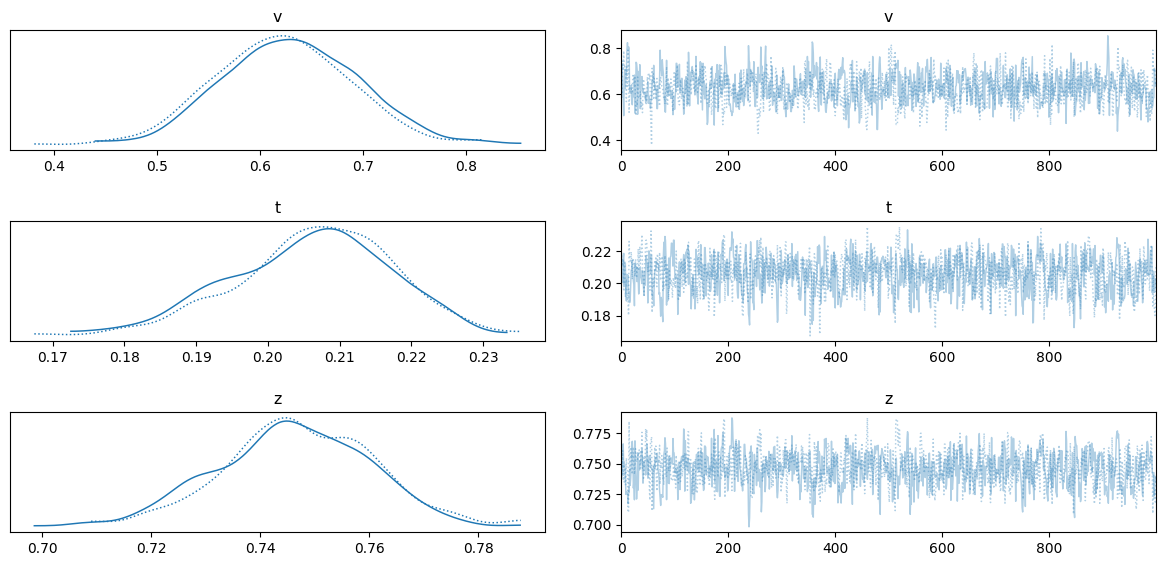

In [67]:
correct_model.plot_trace()


As you can see below from the left plots, the distributions of the 3 (free) parameters center around the true values for $v = 0.6,~t_0 = 0.21,~z = 0.75$. ($t_0$ is labbeled $t$ in the plot below).*Values may vary if you run the code again*

The right plots show the corresponding chains from the MCMC sampling process across the 1000 sampling steps. The chains converge close to the true mean values.

We can summarize results from the fit as follows. In this way we can obtain the mean values of the fitted parameters, along with their standard deviation and high density intervals (hdi).

In [68]:
az.summary(correct_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.206,0.011,0.186,0.226,0.000,0.000,820.0,1272.0,1.0
v,0.626,0.065,0.509,0.747,0.002,0.002,728.0,1091.0,1.0
z,0.747,0.014,0.719,0.770,0.000,0.000,788.0,921.0,1.0


###### **Interpretation of plot results**  

The model parameters were fitted to simulated data generated with true parameters (*v=0.5, a=1.5, z=0.75, t=0.2*).  

- For **correct_model**, where the parameter *a* was fixed at 1.5 (matching the true value), the other three parameters (*v, z, t*) were estimated based on the data.  
- The estimated mean values for these parameters were:(Values may vary when you reran the code)  
  - **v**: 0.068  
  - **z**: 0.074
  - **t**: 0.199

Each estimate fell within the 94% highest density interval (HDI):  
This indicates that the true parameter values are plausible and that *v*, *z*, and *t* were reliably recovered in this simulation.  

This process demonstrates **parameter recovery**—a method of evaluating how well the model can estimate the true parameter values. Fitting the model to simulated data is essential for assessing the reliability of the estimated parameters, especially when the true values are unknown in real-world.  


We can also compare the distribution of reaction times from the dataset with the so-called **posterior predictive distribution** of the fitted model. This is the distribution of reaction times you obtain from sampling the posterior distributions of parameters, and then using those parameters to simulate data, multiple times.

Note that the plot below plots the reaction time distribution for the lower threshold in the negative domain and reaction times for the upper threshold in the positive domain of the "Response Time" axis.

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

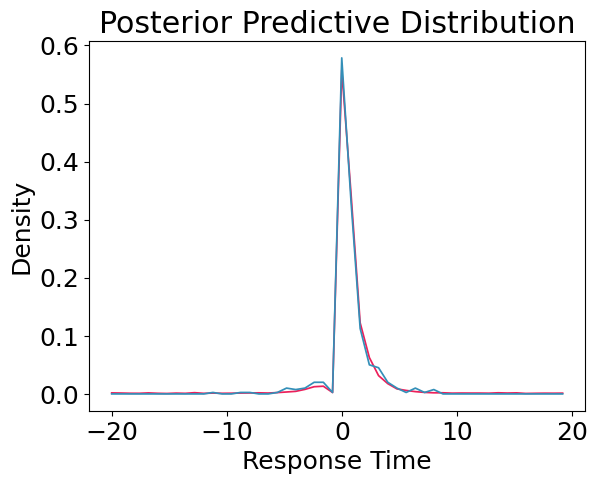

In [69]:
hssm.plotting.plot_posterior_predictive(correct_model)

So far, so good! We fitted the model with the **correct threshold**. Now, let's fit the model with the **wrong threshold** to observe whether we can still estimate the "true" parameters when one parameter is clearly incorrect.  

This exercise is important for evaluating whether our modeling approach can distinguish between a **well-fitting model** and a **poorly-fitting model**. By comparing the results from both models, we can further determine if the model with the correct threshold provides a significantly better fit to the data than the model with the wrong threshold.  


In [71]:
wrong_model_inference = wrong_model.sample(
)

Using default initvals. 



INFO:hssm:Using default initvals. 



Output()

Output()

100%|██████████| 2000/2000 [00:01<00:00, 1497.98it/s]


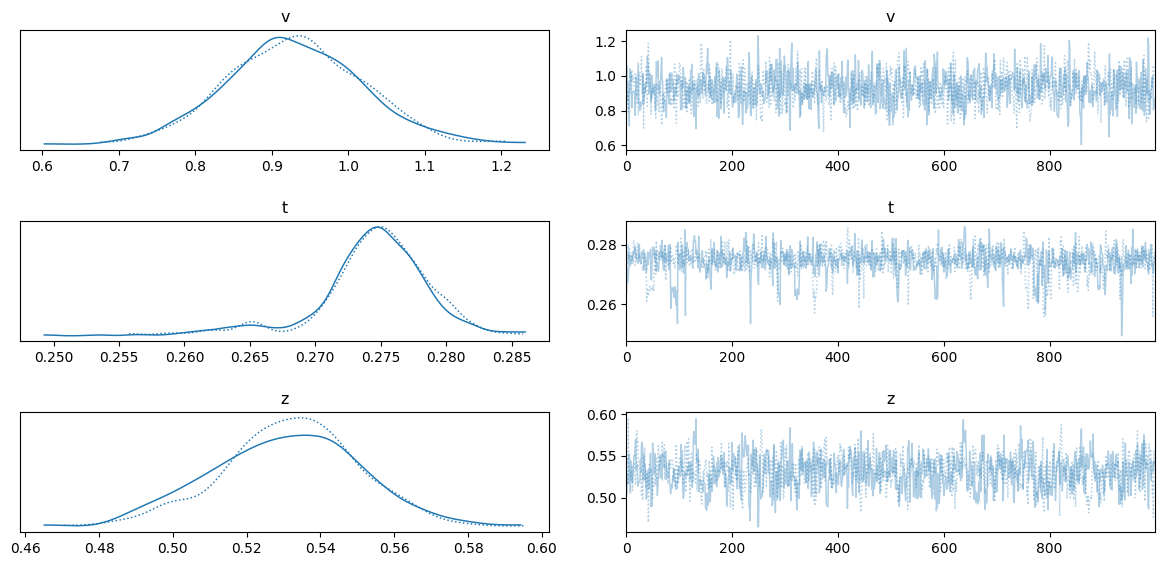

In [72]:
wrong_model.plot_trace()

In [52]:
az.summary(wrong_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.288,0.003,0.283,0.293,0.000,0.000,1387.0,1301.0,1.0
v,0.903,0.088,0.746,1.069,0.002,0.002,1340.0,1358.0,1.0
z,0.532,0.019,0.495,0.564,0.001,0.000,1344.0,1469.0,1.0


###### **Interpretation of plot results**  
- For **wrong_model**, where the parameter *a* was fixed at 0.5 (a value mismatched with the true threshold of 1.5), the other three parameters (*v, z, t*) were estimated based on the data.  

- The estimated mean values for these parameters were (values may vary when you rerun the code):  
  - **v**: 0.534  
  - **z**: 0.259  
  - **t**: 0.911  

- Each estimate almost lies on the border of the 94% highest density interval (HDI).  

This indicates that the true parameter values were not as accurately recovered, highlighting the impact of using an incorrect threshold value for the model. The discrepancy suggests that *v*, *z*, and *t* were less reliably estimated in this simulation.

Now we want to compare the two models using the ArviZ package (imported as `az`). The model comparison is performed using **leave-one-out cross-validation (LOO)** for fitted Bayesian models.

**What is LOO?**  
Leave-one-out cross-validation is a technique used to evaluate how well a model generalizes to unseen data. It involves:  
1. Removing one data point from the dataset.  
2. Fitting the model to the remaining data.  
3. Predicting the removed data point.  
4. Repeating this process for every data point in the dataset.  



In [73]:
model_comparison = az.compare(
    {
        "correct": correct_model.traces,
        "wrong": wrong_model.traces,
    }
)

model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
correct,0,-618.897388,2.739005,0.000000,1.0,33.519391,0.000000,False,log
wrong,1,-1133.228932,7.387823,514.331545,0.0,57.734001,33.349803,True,log


**Note:** *If you obtain NaNs you may have to rerun the fitting process.*

The model comparison assigns a greater ``weight`` to the correct model, suggesting a better fit. Further more, the the **expected log pointwise predictive density (elpd)** of the leave-one-out (loo) cross-validation under the estimated model is higher for the correct model compared to the wrong model. Since this is a cross-validation, this metric accounts implicitly for model complexity.

**The important take away is**: Higher ``elpd_loo`` values mean better fit.

Finally, we can visualize the model comparison:

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

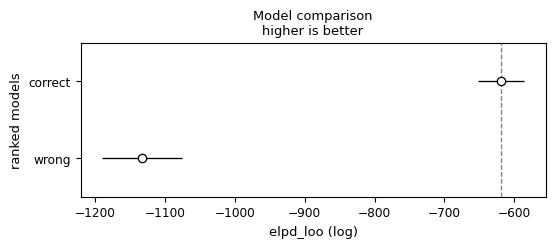

In [74]:
az.plot_compare(model_comparison)

### Back to the modeling

We assume (based on testing four different models and selecting the best-performing one) that the model which incorporates a dependence on the **drift rate** can account for the **task-switching effect**.  

If you’re skeptical, you can conduct your own model comparison in the **Bonus Section**!  

This model effectively captures the task-switching effect by modeling its dependence on the drift rate.  

Next, we define this model by fitting it to our human behavioral data.  


### <font color="red">Exercise 5a (1 point) </font>
<font color="red">1. **Estimate Parameters**  
   Fit the model to the data and estimate the parameters (*v, a, z, t*).  

</font>

In [88]:
varying_drift_model = hssm.HSSM(
    #fit human behavioral data to model(it is the same as in tutorial)
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + switch",
        }
    ],
    model="ddm",
    data=human_df[['rt', 'response', 'switch']]
)

varying_drift_model_inference = varying_drift_model.sample()

Model initialized successfully.


INFO:hssm:Model initialized successfully.


Using default initvals. 



INFO:hssm:Using default initvals. 



Output()

Output()

ERROR:pymc.stats.convergence:There were 1590 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 2000/2000 [00:00<00:00, 3730.85it/s]


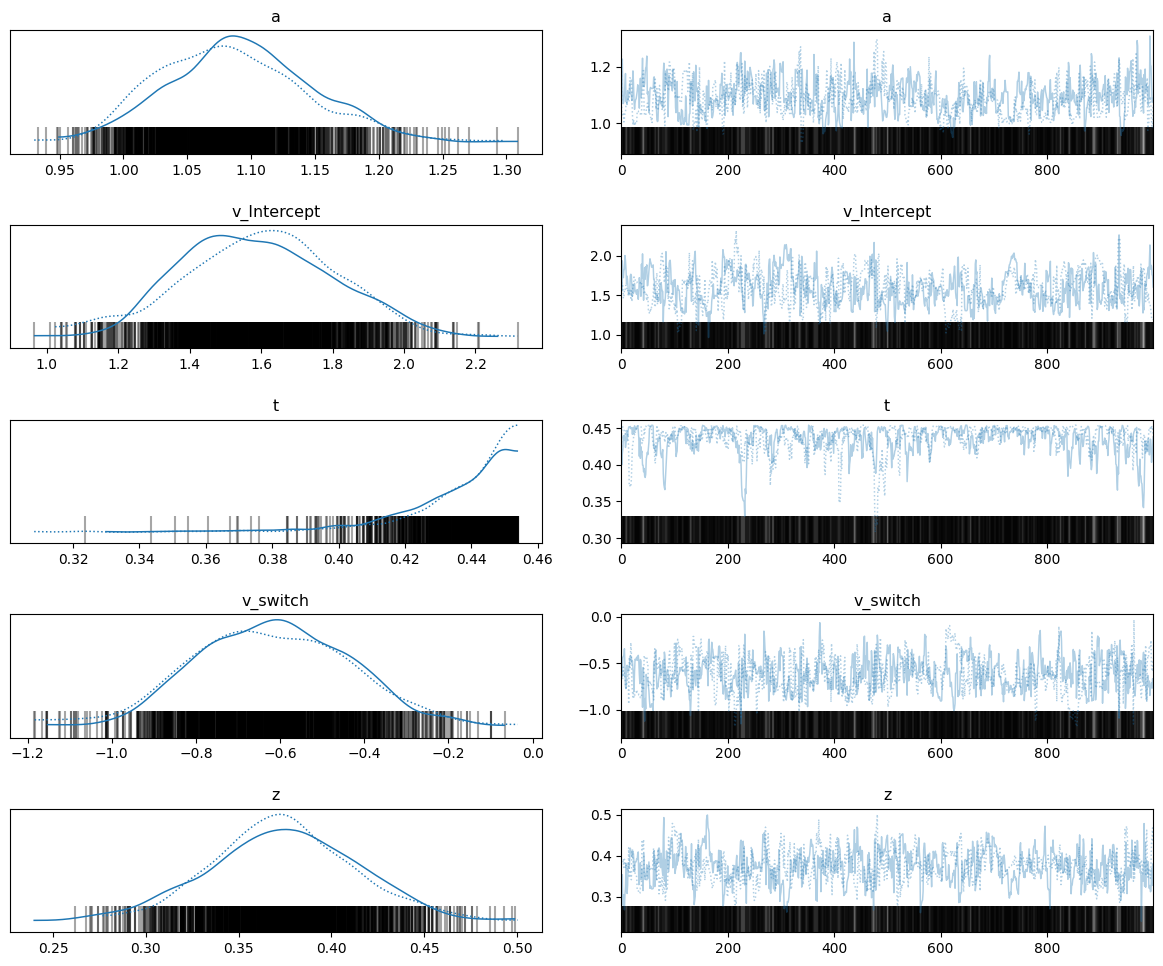

In [89]:
varying_drift_model.plot_trace()

In [92]:
az.summary(varying_drift_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.090,0.058,0.983,1.196,0.004,0.003,201.0,448.0,1.01
v_Intercept,1.594,0.212,1.219,2.006,0.015,0.011,202.0,224.0,1.00
t,0.436,0.019,0.403,0.454,0.002,0.001,191.0,239.0,1.03
v_switch,-0.619,0.183,-0.941,-0.276,0.012,0.009,238.0,292.0,1.01
z,0.374,0.039,0.302,0.448,0.002,0.002,258.0,421.0,1.01


### <font color="red">Exercise 5b (1 point) </font>
<font color="red"> 2. **Plot and Interpret (1 Point)**  
   Plot the parameter distributions and provide an interpretation of the results. *(max 80 words)*

In [ ]:
# Edit this variable to provide your answer
answer_5_b = "The t parameter is at the edge of the sample space, suggesting the true value is larger. There were divergence issues in fitting the data. The estimates for a, v_intercept, v_switch, and z are well within the HDI, indicating a good fit. However, some uncertainty remains, shown by the high variance in the right plots, likely due to the limited sample size."

#**Bonus: Model Comparison**

### Bonus Task: Comparing Model Performance  

So you're skeptical or curious? Both attitudes are fantastic—it’s good to question everything in modeling! Let’s take a closer look at comparing model performance then.  

To demonstrate that our selected model performs better than an alternative, we will compare the following two models:  

1. **Correct Model**: This model assumes a dependence on the **drift rate**, effectively capturing the **task-switching effect**.  
2. **Stable Model**: This model assumes **stable parameters**, with no dependence on **task-switching**.  


Your task: Conduct the model comparison and interpret the results!  
*Hint: you may use hssm mini tutorial*

In [ ]:
stable_model = hssm.HSSM(
    # (Hint: To initialize a model with stable parameters,
    # you can simply fit it to the data without any specific parameter dependencies!)
    # hello there
)

Thank you for working through this notebook! Keep questioning and exploring—modeling is as much about the journey as it is about the results. 🚀  